# Bayesian Network Implementation for Predicting Song Popularity
In this project, we implemented three distinct Bayesian Network models to predict the popularity of a song. These models include:

TAN (Tree Augmented Naive Bayes): Built manually by carefully structuring the

1.   TAN (Tree Augmented Naive Bayes): Built manually by carefully structuring the relationships between features based on domain knowledge and dependencies.
2.   Tree Search: Utilized a tree search algorithm to optimize the structure of the Bayesian Network, aiming for the best prediction accuracy.
3.   Tabu Search: Applied the Tabu search algorithm to refine the model structure further, exploring local solutions while avoiding previously visited ones, leading to improved performance.

Each model leveraged the power of probabilistic inference to make predictions on song popularity based on various audio features. The goal was to understand how different musical attributes contribute to a song’s popularity and to predict this outcome with greater accuracy.

In [ ]:
!pip install pgmpy --quiet

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pgmpy.models import BayesianNetwork
from pgmpy.models import BayesianModel
from pgmpy.estimators import MaximumLikelihoodEstimator
from pgmpy.inference import VariableElimination
import networkx as nx
from pgmpy.factors.discrete import TabularCPD
from pgmpy.estimators import TreeSearch, BDeuScore, HillClimbSearch, BDeuScore
import warnings
warnings.filterwarnings("ignore")


## Spotify Tracks Dataset Overview 🎵
This dataset provides a comprehensive collection of Spotify tracks across 125 genres, compiled using Spotify's Web API and Python. It includes detailed audio features, artist information, and popularity metrics.
Key Features
####🎤 General Information
- artists: Name of the performing artist(s).
- album_name: Title of the album containing the track.
- track_name: Name of the track.
- popularity: Score (0-100) indicating the track’s popularity.
- duration_ms: Track duration in milliseconds.
- explicit: Boolean indicating explicit content.
####🎼 Audio Features
- Danceability: Suitability for dancing (0-1).
- Energy: Intensity and activity level (0-1).
- Loudness: Overall volume in decibels (dB).
- Key: Musical key (0-11).
- Valence: Positiveness of the song (0-1).
- Tempo: Speed of the track in beats per minute (BPM).
- Speechiness: Presence of spoken words.
- Acousticness: Degree of acoustic sound.
- Instrumentalness: Likelihood of being instrumental.
- Liveness: Probability of a live audience presence.
- Time Signature: Bar structure of the track.


In [ ]:
df=pd.read_csv('spotify_data.csv')
df=df.sample(n=9000, random_state=42)
df.head()

,Unnamed: 0,track_id,artists,album_name,track_name,popularity,duration_ms,explicit,danceability,energy,...,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre
113186,113186,6KwkVtXm8OUp2XffN5k7lY,Hillsong Worship,No Other Name,No Other Name,50,440247,False,0.369,0.598,...,-6.984,1,0.0304,0.00511,0.000000,0.176,0.0466,148.014,4,world-music
42819,42819,2dp5I5MJ8bQQHDoFaNRFtX,Internal Rot,Grieving Birth,Failed Organum,11,93933,False,0.171,0.997,...,-3.586,1,0.1180,0.00521,0.801000,0.420,0.0294,122.223,4,grindcore
59311,59311,5avw06usmFkFrPjX8NxC40,Zhoobin Askarieh;Ali Sasha,Noise A Noise 20.4-1,"Save the Trees, Pt. 1",0,213578,False,0.173,0.803,...,-10.071,0,0.1440,0.61300,0.001910,0.195,0.0887,75.564,3,iranian
91368,91368,75hT0hvlESnDJstem0JgyR,Bryan Adams,All I Want For Christmas Is You,Merry Christmas,0,151387,False,0.683,0.511,...,-5.598,1,0.0279,0.40600,0.000197,0.111,0.5980,109.991,3,rock
61000,61000,4bY2oZGA5Br3pTE1Jd1IfY,Nogizaka46,バレッタ TypeD,月の大きさ,57,236293,False,0.555,0.941,...,-3.294,0,0.0481,0.48400,0.000000,0.266,0.8130,92.487,4,j-idol


For our experiment, we did:


*   Feature Selection by removing the features that couldn't be used like track, album , artistis names
*   Removing Features with redundant information
*   Creating bins for continuous values
*   Reducing the number of track_genres by combining the closest ones. Too many genres add so much computing time



In [ ]:
df=df[['mode','key','time_signature','valence','energy','speechiness','danceability','tempo','loudness','track_genre','popularity']]
df = df.dropna()

In [ ]:
# Discretize continuous variables
columns_to_bin = ["popularity", "danceability", "tempo", "energy", "valence", "speechiness", "loudness","mode"	,"key",	"time_signature"]

for col in columns_to_bin:
    df[col] = pd.cut(df[col], bins=3, labels=["low", "medium", "high"])

Let's check the distribution of our target variable. This parameter is very important because it influences the way our network behaves. It is normal to have more values that are low or medium popularity. But we'll try to change the distribution of our target variable to lessen this affect

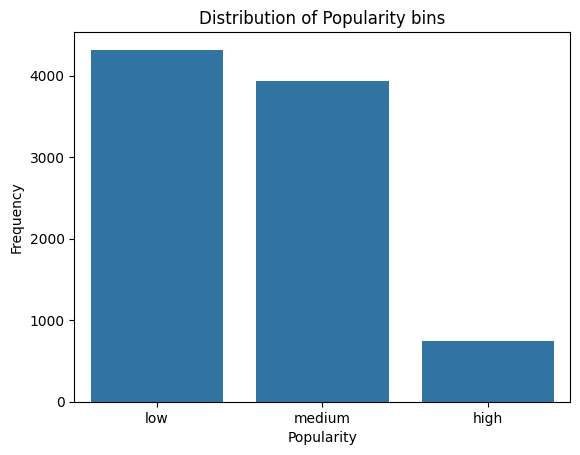

In [ ]:
sns.countplot(x='popularity', data=df) # or sns.countplot(y='target', data=df) for horizontal
plt.xlabel("Popularity")
plt.ylabel("Frequency")
plt.title("Distribution of Popularity bins")
plt.show()

In [ ]:
#df = df.groupby('popularity', group_keys=False).apply(lambda x: x.sample(df['popularity'].value_counts().min(), replace=True))


In [ ]:
df.shape

(9000, 11)

In [ ]:
df['track_genre'].unique()

array(['world-music', 'grindcore', 'iranian', 'rock', 'j-idol', 'samba',
       'comedy', 'metalcore', 'disco', 'r-n-b', 'country', 'j-pop',
       'tango', 'pagode', 'acoustic', 'hardstyle', 'pop', 'reggae',
       'metal', 'electro', 'club', 'kids', 'chicago-house', 'j-dance',
       'rock-n-roll', 'dancehall', 'show-tunes', 'alternative', 'new-age',
       'dance', 'piano', 'techno', 'funk', 'reggaeton', 'electronic',
       'bluegrass', 'industrial', 'blues', 'singer-songwriter',
       'afrobeat', 'happy', 'swedish', 'rockabilly', 'j-rock',
       'heavy-metal', 'chill', 'k-pop', 'sleep', 'mandopop', 'punk',
       'french', 'german', 'sad', 'deep-house', 'pop-film', 'folk',
       'forro', 'dubstep', 'idm', 'edm', 'guitar', 'disney', 'indie-pop',
       'death-metal', 'groove', 'party', 'cantopop', 'latino', 'soul',
       'indian', 'drum-and-bass', 'mpb', 'malay', 'black-metal',
       'honky-tonk', 'garage', 'sertanejo', 'psych-rock', 'study',
       'gospel', 'latin', 'spanish

We also need to map all te unique values of music genres, there are initially 125 of them and we need to take in consideration that the sampling chages them everytime

In [ ]:
# Define the genre mapping
genre_mapping = {
    'pop': 'Pop',
    'j-pop': 'Pop',
    'k-pop': 'Pop',
    'indie-pop': 'Pop',
    'power-pop': 'Pop',
    'synth-pop': 'Pop',
    'rock': 'Rock',
    'alternative': 'Rock',
    'rock-n-roll': 'Rock',
    'rockabilly': 'Rock',
    'hard-rock': 'Rock',
    'punk-rock': 'Rock',
    'grunge': 'Rock',
    'emo': 'Rock',
    'psych-rock': 'Rock',
    'progressive-house': 'Rock',
    'metal': 'Metal',
    'heavy-metal': 'Metal',
    'death-metal': 'Metal',
    'black-metal': 'Metal',
    'metalcore': 'Metal',
    'grindcore': 'Metal',
    'electronic': 'Electronic/Dance',
    'dance': 'Electronic/Dance',
    'edm': 'Electronic/Dance',
    'techno': 'Electronic/Dance',
    'house': 'Electronic/Dance',
    'deep-house': 'Electronic/Dance',
    'detroit-techno': 'Electronic/Dance',
    'minimal-techno': 'Electronic/Dance',
    'trance': 'Electronic/Dance',
    'dubstep': 'Electronic/Dance',
    'drum-and-bass': 'Electronic/Dance',
    'hardstyle': 'Electronic/Dance',
    'hardcore': 'Electronic/Dance',
    'breakbeat': 'Electronic/Dance',
    'idm': 'Electronic/Dance',
    'hip-hop': 'Hip-Hop/Rap',
    'reggaeton': 'Hip-Hop/Rap',
    'dancehall': 'Hip-Hop/Rap',
    'r-n-b': 'R&B/Soul',
    'soul': 'R&B/Soul',
    'funk': 'R&B/Soul',
    'gospel': 'R&B/Soul',
    'jazz': 'Jazz/Blues',
    'blues': 'Jazz/Blues',
    'swedish': 'Jazz/Blues',
    'guitar': 'Jazz/Blues',
    'piano': 'Jazz/Blues',
    'classical': 'Classical/Opera',
    'opera': 'Classical/Opera',
    'romance': 'Classical/Opera',
    'new-age': 'Classical/Opera',
    'country': 'Country/Folk',
    'folk': 'Country/Folk',
    'bluegrass': 'Country/Folk',
    'honky-tonk': 'Country/Folk',
    'singer-songwriter': 'Country/Folk',
    'songwriter': 'Country/Folk',
    'world-music': 'World Music',
    'afrobeat': 'World Music',
    'latin': 'World Music',
    'brazil': 'World Music',
    'salsa': 'World Music',
    'tango': 'World Music',
    'samba': 'World Music',
    'pagode': 'World Music',
    'forro': 'World Music',
    'sertanejo': 'World Music',
    'reggae': 'World Music',
    'dub': 'World Music',
    'ska': 'World Music',
    'turkish': 'World Music',
    'iranian': 'World Music',
    'indian': 'World Music',
    'malay': 'World Music',
    'spanish': 'World Music',
    'french': 'World Music',
    'german': 'World Music',
    'chicago-house': 'World Music',
    'garage': 'World Music',
    'kids': 'Children/Disney',
    'disney': 'Children/Disney',
    'children': 'Children/Disney',
    'ambient': 'Ambient/Chill',
    'chill': 'Ambient/Chill',
    'sleep': 'Ambient/Chill',
    'study': 'Ambient/Chill',
    'happy': 'Ambient/Chill',
    'sad': 'Ambient/Chill',
    'comedy': 'Other',
    'show-tunes': 'Other',
    'anime': 'Other',
    'j-idol': 'Other',
    'j-dance': 'Other',
    'j-rock': 'Other',
    'cantopop': 'Other',
    'mandopop': 'Other',
    'goth': 'Other',
    'industrial': 'Other',
    'groove': 'Other',
    'party': 'Other'
}

# Apply the mapping to the dataset
df['track_genre'] = df['track_genre'].map(genre_mapping)
df=df.dropna()

In [ ]:
df.head()

,mode,key,time_signature,valence,energy,speechiness,danceability,tempo,loudness,track_genre,popularity
113186,high,medium,high,low,medium,low,medium,medium,high,World Music,medium
42819,high,medium,high,low,high,low,low,medium,high,Metal,low
59311,low,high,medium,low,high,low,low,low,high,World Music,low
91368,high,medium,medium,medium,medium,low,high,medium,high,Rock,low
61000,low,high,high,high,high,low,medium,medium,high,Other,medium


## TAN Network
We constructed the TAN Network by following this logic:
1. track_genre as Root :Genre influences many features like danceability, tempo, and loudness.
2. track_genre → danceability, tempo, loudness
Why? Genre determines:

    danceability: Pop/EDM = high, Classical = low.

    tempo: Dance = fast, Ballads = slow.

    loudness: Rock = loud, Acoustic = soft.
3. danceability → valence
Why? Danceable tracks are often upbeat and positive (high valence).

4. tempo → energy
Why? Faster tracks (tempo) tend to have higher energy.

5. loudness → speechiness
Why? Loud genres (e.g., hip-hop, rock) often have more spoken words (high speechiness).

6. valence → mode
Why? Positive tracks (valence) are more likely to be in a major key (mode).

7. mode → key
Why? Major/minor keys (mode) influence the harmonic structure (key).

8. key → time_signature
Why? Certain keys are associated with specific time signatures (e.g., 4/4 for pop).
9. All Features → popularity
Why? Popularity is influenced by all features (e.g., danceable, loud, and positive tracks are often more popular).

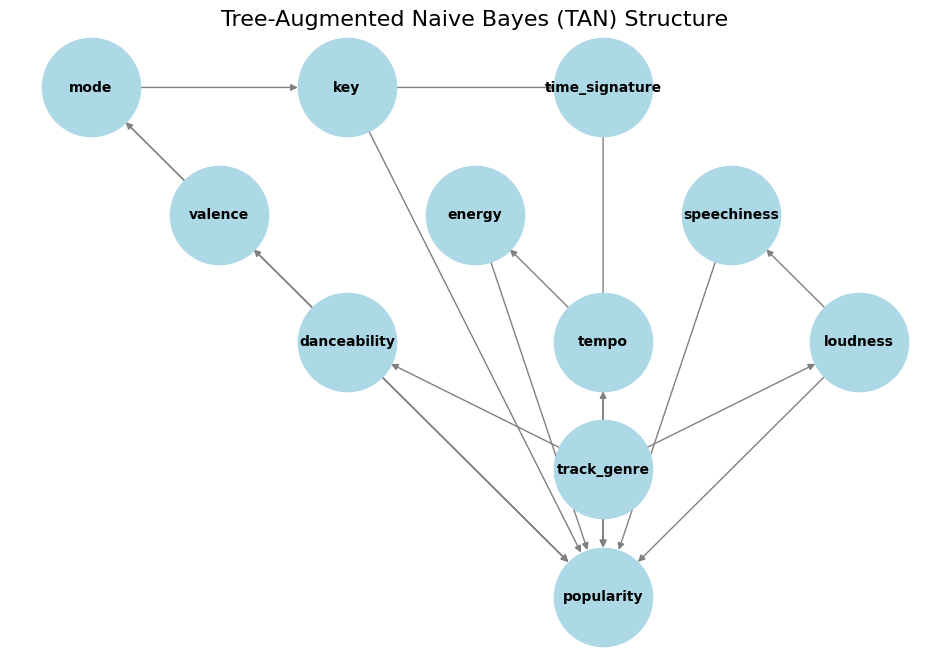

In [ ]:
# Definition the TAN structure
tan_model = BayesianNetwork([
    # Tree structure among features
    ('track_genre', 'danceability'),
    ('track_genre', 'tempo'),
    ('track_genre', 'loudness'),
    ('danceability', 'valence'),
    ('tempo', 'energy'),
    ('loudness', 'speechiness'),
    ('valence', 'mode'),
    ('mode', 'key'),
    ('key', 'time_signature'),

    # link to poplarity
    ('track_genre', 'popularity'),
    ('danceability', 'popularity'),
    ('tempo', 'popularity'),
    ('loudness', 'popularity'),
    ('valence', 'popularity'),
    ('energy', 'popularity'),
    ('speechiness', 'popularity'),
    ('mode', 'popularity'),
    ('key', 'popularity'),
    ('time_signature', 'popularity')
])

# Visualization the TAN structure
pos = {
    'popularity': [0, 0],

    'track_genre': [0, 1],
    'danceability': [-2, 2],
    'tempo': [0, 2],
    'loudness': [2, 2],
    'valence': [-3, 3],
    'energy': [-1, 3],
    'speechiness': [1, 3],
    'mode': [-4, 4],
    'key': [-2, 4],
    'time_signature': [0, 4]
}


plt.figure(figsize=(12, 8))
nx.draw_networkx(
    tan_model,
    pos=pos,
    with_labels=True,
    node_size=5000,
    node_color='lightblue',
    edge_color='gray',
    font_size=10,
    font_weight='bold',
    arrows=True
)
plt.title('Tree-Augmented Naive Bayes (TAN) Structure', fontsize=16)
plt.axis('off')  # Hide axes
plt.show()

## Tree Search

In [ ]:
ts = TreeSearch(data=df, root_node='track_genre')

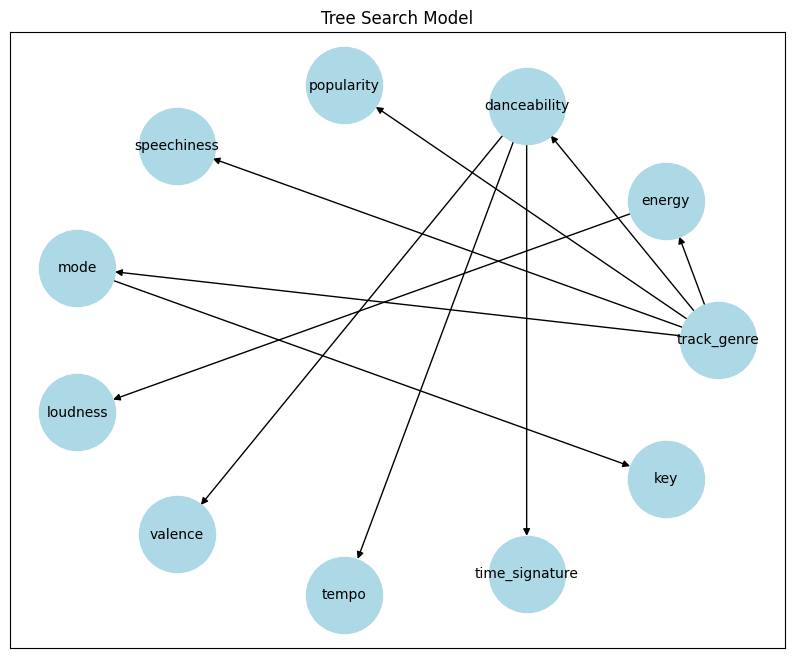

In [ ]:

tree_model = ts.estimate(show_progress=False)
tree_model = BayesianNetwork(tree_model.edges())
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
nx.draw_networkx(tree_model, pos=nx.drawing.layout.circular_layout(tree_model), ax=ax, node_size=3000, with_labels=True, font_size=10, node_color='lightblue')
ax.set_title('Tree Search Model')
plt.show()

Description of the network:\
**Hierarchical Structure:**

The network has a clear hierarchy, with track_genre at the top, influencing intermediate nodes (danceability, energy, mode), which in turn influence leaf nodes. This structure reflects a logical flow of dependencies.

**Causal Relationships**\
The edges suggest causal relationships. For example:

track_genre → danceability → tempo: The genre determines how danceable a track is, and danceability affects the tempo.

track_genre → energy → loudness: The genre determines the energy level, which affects the loudness.


In this Tree ,some relationships might be missing based on domain knowledge. For example:

*    valence (positiveness of a track) could be influenced by mode (major/minor), but this relationship is not captured in the network.

*    loudness could also be influenced by tempo, but this is not reflected in the structure.

## Tabu Search

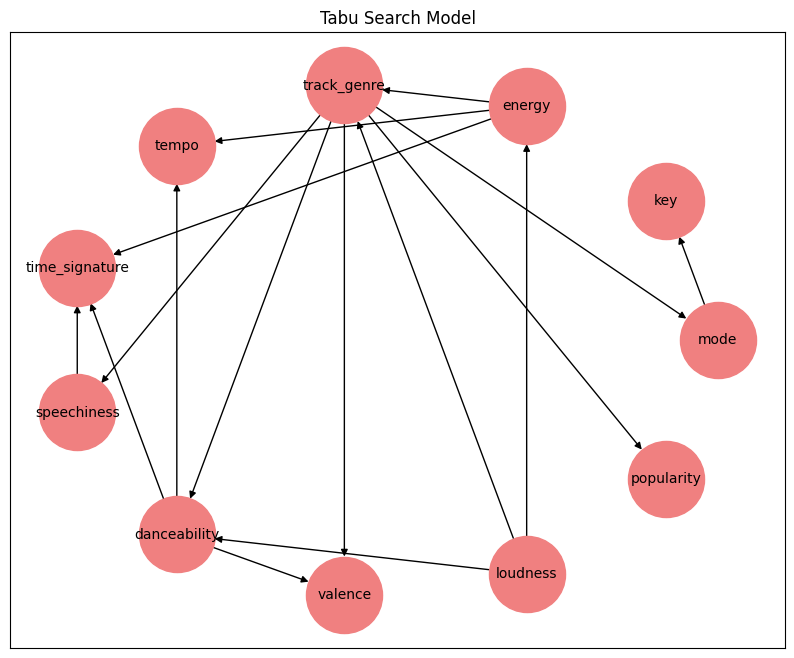

In [ ]:
scorer = BDeuScore(data=df)
hc_tabu = HillClimbSearch(data=df)
hc_tabu_model = hc_tabu.estimate(
    scoring_method=scorer,
    max_iter=100,  # Limit the number of iterations
    black_list=[(u, v) for u in df.columns for v in df.columns if u == v],  # Avoid self-loops
    show_progress=False
)

# Convert to BayesianModel
hc_tabu_model = BayesianNetwork(hc_tabu_model.edges())
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
nx.draw_networkx(hc_tabu_model, pos=nx.drawing.layout.circular_layout(hc_tabu_model), ax=ax, node_size=3000, with_labels=True, font_size=10, node_color='lightcoral')
ax.set_title('Tabu Search Model')
plt.show()

**Unusual Relationships:**

energy → track_genre: This is an unusual relationship because track_genre is typically considered a fixed attribute. It might indicate that high-energy tracks are more likely to belong to certain genres (e.g., Rock or Metal), but this relationship should be validated with domain knowledge or data analysis.

**Potential Missing Relationships:**

Some relationships might be missing based on domain knowledge. For example:

valence could be influenced by mode (major/minor), but this relationship is not captured in the network.

loudness could also be influenced by energy, but this is not reflected in the structure.

## Learning the networks parameters (CDPs)

In [ ]:
from pgmpy.estimators import MaximumLikelihoodEstimator

# Recreate the models with the updated dataset
models = [('TAN', tan_model), ('tree', tree_model), ('hc tabu', hc_tabu_model)]

for name, model in models:
    print(f'Computing CPDs for {name} model')
    model.fit(df, estimator=MaximumLikelihoodEstimator)

Computing CPDs for TAN model
Computing CPDs for tree model
Computing CPDs for hc tabu model


## Inference


In [ ]:
from pgmpy.inference import VariableElimination

# Initialize inference engines for all models
inferences = {
    'TAN': VariableElimination(tan_model),
    'Tree Search': VariableElimination(tree_model),
    'Tabu Search': VariableElimination(hc_tabu_model)
}


### Question 1: How do danceability and valence affect popularity? Which one is more impactful?

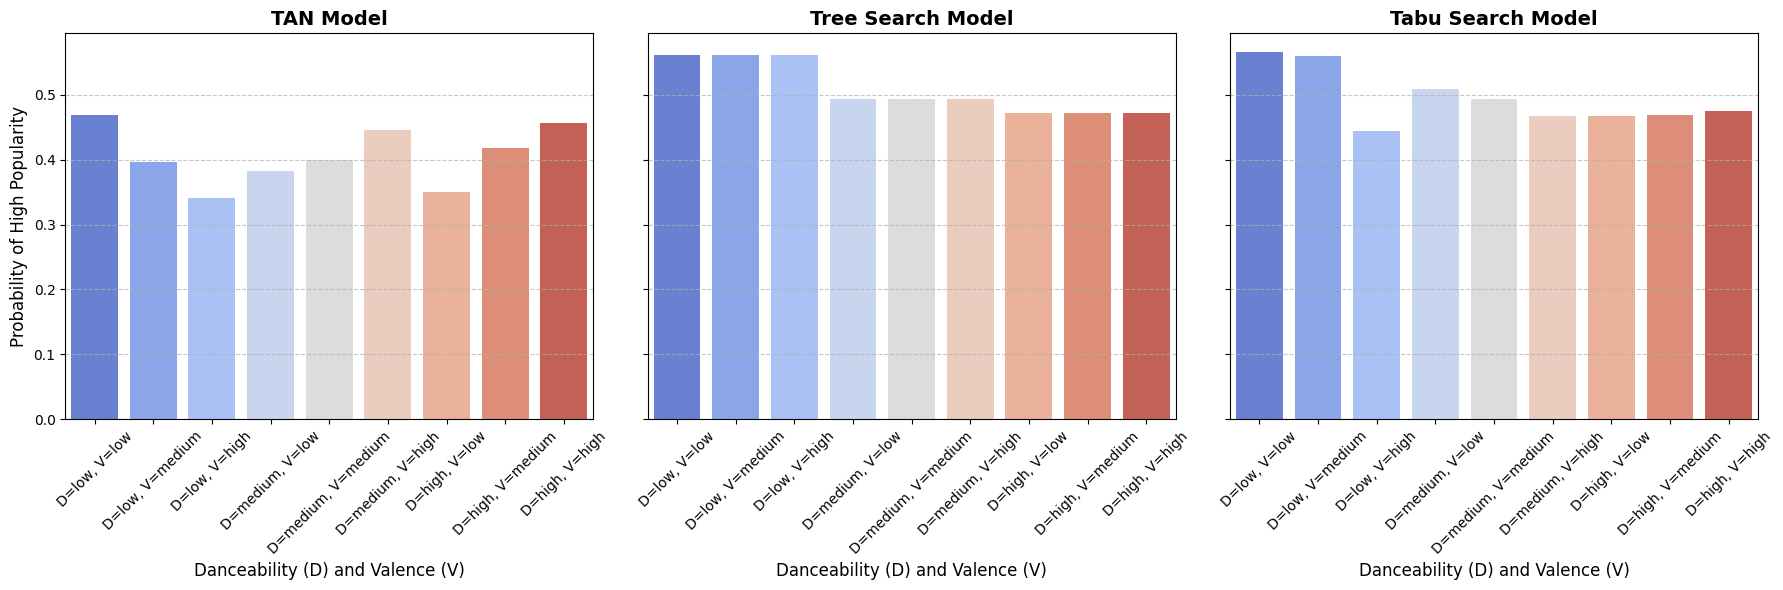

In [ ]:
# Define scenarios for danceability and valence
scenarios = [(d, v) for d in ["low", "medium", "high"] for v in ["low", "medium", "high"]]

# Perform inference and store results
results = {}
for model_name, ve in inferences.items():
    results[model_name] = {}
    for d, v in scenarios:
        evidence = {'danceability': d, 'valence': v}
        results[model_name][(d, v)] = ve.query(variables=['popularity'], evidence=evidence).values

# Visualize results
# Define a color palette
colors = sns.color_palette("coolwarm", len(scenarios))

# Visualize results
fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)

for i, (model_name, probs) in enumerate(results.items()):
    ax = axes[i]
    sns.barplot(
        x=[f"D={d}, V={v}" for d, v in scenarios],
        y=[probs[(d, v)][1] for d, v in scenarios],
        ax=ax,
        palette=colors
    )
    ax.set_title(f'{model_name} Model', fontsize=14, fontweight='bold')
    ax.set_ylabel('Probability of High Popularity', fontsize=12)
    ax.set_xlabel('Danceability (D) and Valence (V)', fontsize=12)
    ax.tick_params(axis='x', rotation=45)  # Rotate x-axis labels for better readability
    ax.grid(axis='y', linestyle='--', alpha=0.7)  # Add subtle gridlines

plt.tight_layout()
plt.show()

## Question 2: Which track_genre should an artist choose to maximize popularity?

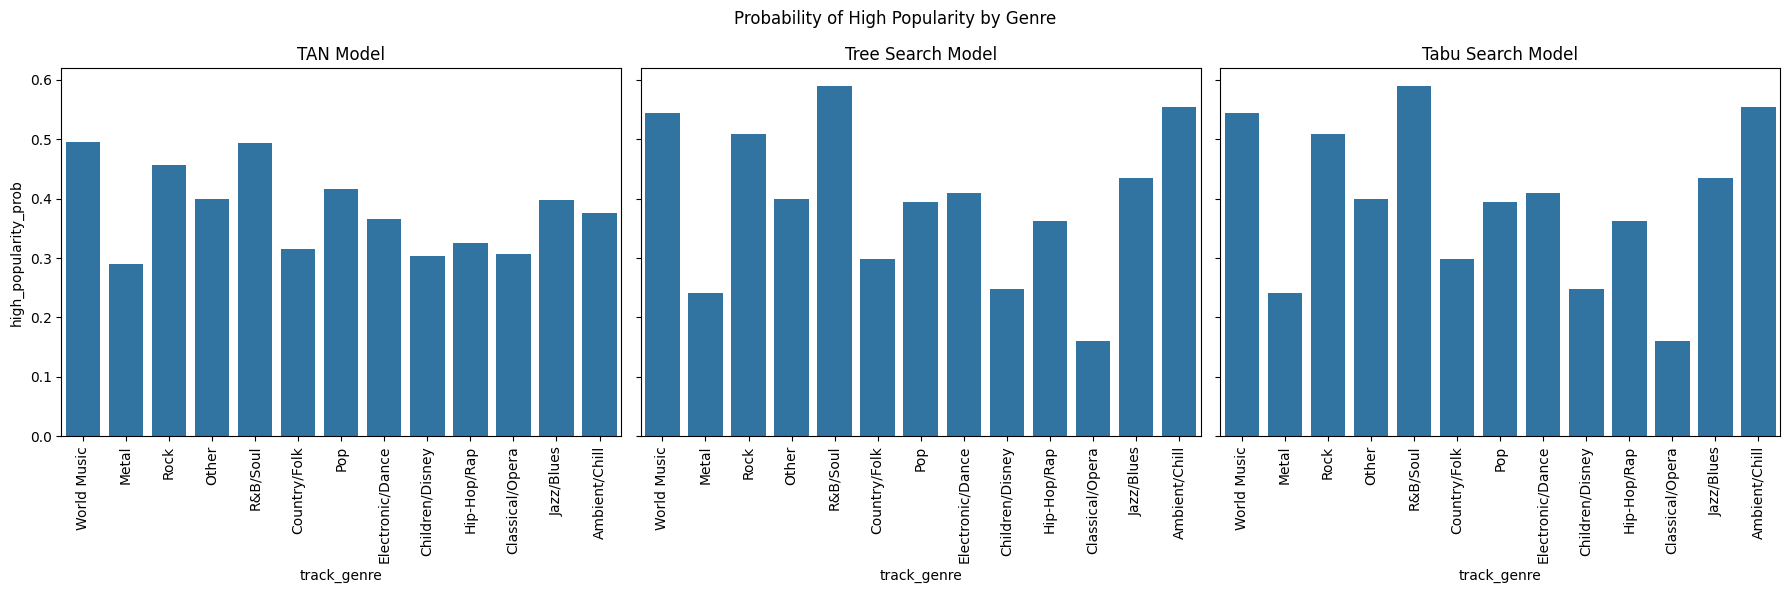

In [ ]:
# Query: Probability of high popularity for each genre
results = {}
for model_name, inference in inferences.items():
    genre_probs = []
    for genre in ['World Music', 'Metal', 'Rock', 'Other', 'R&B/Soul',
       'Country/Folk', 'Pop', 'Electronic/Dance', 'Children/Disney',
       'Hip-Hop/Rap', 'Classical/Opera', 'Jazz/Blues', 'Ambient/Chill']:
        query = inference.query(variables=['popularity'], evidence={'track_genre': genre})
        high_pop_prob = query.values[2]  # Index 2 corresponds to 'high'
        genre_probs.append((genre, high_pop_prob))
    results[model_name] = pd.DataFrame(genre_probs, columns=['track_genre', 'high_popularity_prob'])

# Visualize results
fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)
for i, (model_name, result) in enumerate(results.items()):
    sns.barplot(x='track_genre', y='high_popularity_prob', data=result, ax=axes[i])
    axes[i].set_title(f'{model_name} Model')
    axes[i].tick_params(axis='x', rotation=90)
plt.suptitle('Probability of High Popularity by Genre')
plt.tight_layout()
plt.show()

Question 3 :What is the optimal combination of features for high popularity?

In [ ]:
# Define possible values for key features
feature_values = {
    'danceability': ['low', 'medium', 'high'],
    'loudness': ['low', 'medium', 'high'],
    'tempo': ['low', 'medium', 'high']
}

# Query: Find the combination with the highest probability of high popularity
results = {}
for model_name, inference in inferences.items():
    max_prob = 0
    best_combo = None
    for dance in feature_values['danceability']:
        for loud in feature_values['loudness']:
            for temp in feature_values['tempo']:
                query = inference.query(variables=['popularity'], evidence={'danceability': dance, 'loudness': loud, 'tempo': temp})
                high_pop_prob = query.values[2]  # Index 2 corresponds to 'high'
                if high_pop_prob > max_prob:
                    max_prob = high_pop_prob
                    best_combo = (dance, loud, temp)
    results[model_name] = {'best_combo': best_combo, 'max_prob': max_prob}

# Visualize results
for model_name, result in results.items():
    print(f'{model_name} Model:')
    print(f'Optimal Combination: Danceability={result["best_combo"][0]}, Loudness={result["best_combo"][1]}, Tempo={result["best_combo"][2]}')
    print(f'Probability of High Popularity: {result["max_prob"]:.2f}\n')

TAN Model:
Optimal Combination: Danceability=medium, Loudness=high, Tempo=medium
Probability of High Popularity: 0.46

Tree Search Model:
Optimal Combination: Danceability=high, Loudness=high, Tempo=low
Probability of High Popularity: 0.45

Tabu Search Model:
Optimal Combination: Danceability=low, Loudness=low, Tempo=high
Probability of High Popularity: 0.48

